<a href="https://colab.research.google.com/github/KulissaraSingha/Eyes_Status_Classfication/blob/main/Are_you_sleeping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import cv2

In [21]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten, Conv2D, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import decode_predictions

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K

In [23]:
print(tf.__version__)

2.7.0


### Mount with Google drive

In [24]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Download dataset

In [26]:
train_path = ('/content/drive/MyDrive/dataset_new/eyes_train')
test_path = ('/content/drive/MyDrive/dataset_new/eyes_test')

directories = ['/Closed', '/Open']

### Data Generator

In [6]:
def plot_imgs(directory, top=10):
    all_item_dirs = os.listdir(directory)
    item_files = [os.path.join(directory, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(20, 20))
  
    for i, img_path in enumerate(item_files):
        plt.subplot(10, 10, i+1)
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

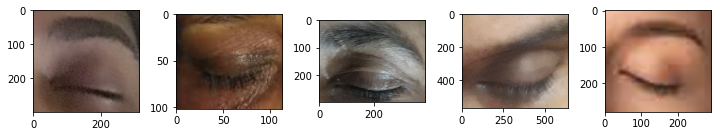

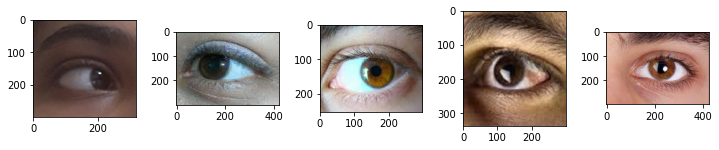

In [10]:
for j in directories:
    plot_imgs(train_path+j)

In [11]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,  
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   validation_split= 0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


eyes_train = train_datagen.flow_from_directory(
    directory = train_path, 
    target_size=(224, 224),
    classes =['Closed', 'Open'],
    batch_size= 32,
    shuffle = True,
    subset="training")

eyes_val = train_datagen.flow_from_directory(\
    directory = train_path, 
    target_size=(224, 224),
    classes =['Closed', 'Open'],
    batch_size= 32,
    shuffle = True,
    subset="validation")


eyes_test = test_datagen.flow_from_directory(\
    directory=test_path, 
    target_size=(224,224), 
    classes =['Closed', 'Open'],
    batch_size=32, 
    shuffle= True)


Found 988 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


### CNN from Scratch

### Transfer Learning

Use pre-trained modelst to fit with data and find the best given accuracy and minimum loss

#### 1. VGG19 libraries

In [12]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import VGG19

from tensorflow.keras.applications.mobilenet import decode_predictions
from pprint import pprint

In [14]:
# Apply Transfer Learning
K.clear_session()

VGG19_base = tf.keras.applications.VGG19(
    include_top = False,
    input_shape = (224,224,3))

VGG19_base.trainable = False 

modelVGG19 = models.Sequential()

modelVGG19.add(VGG19_base)
modelVGG19.add(layers.Flatten())
modelVGG19.add(layers.Dense(32, activation ="relu"))
modelVGG19.add(layers.Dense(2, activation ="sigmoid"))

modelVGG19.summary()


80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 20,827,298
Trainable params: 802,914
Non-trainable params: 20,024,384
_________________________________________________________________


In [15]:
modelVGG19.compile(
    optimizer ="adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = modelVGG19.fit(
    eyes_train,
    epochs = 20,
    validation_data = eyes_val)

Epoch 1/20
31/31 [==============================] - 412s 13s/step - loss: 0.5061 - accuracy: 0.7733 - val_loss: 0.3597 - val_accuracy: 0.8862
Epoch 2/20
31/31 [==============================] - 17s 544ms/step - loss: 0.2786 - accuracy: 0.9018 - val_loss: 0.3045 - val_accuracy: 0.8374
Epoch 3/20
31/31 [==============================] - 17s 545ms/step - loss: 0.2157 - accuracy: 0.9281 - val_loss: 0.2124 - val_accuracy: 0.9146
Epoch 4/20
31/31 [==============================] - 17s 547ms/step - loss: 0.2023 - accuracy: 0.9372 - val_loss: 0.2004 - val_accuracy: 0.9228
Epoch 5/20
31/31 [==============================] - 17s 542ms/step - loss: 0.1688 - accuracy: 0.9474 - val_loss: 0.2175 - val_accuracy: 0.9187
Epoch 6/20
31/31 [==============================] - 17s 545ms/step - loss: 0.2337 - accuracy: 0.9069 - val_loss: 0.1895 - val_accuracy: 0.9187
Epoch 7/20
31/31 [==============================] - 17s 551ms/step - loss: 0.1961 - accuracy: 0.9261 - val_loss: 0.1809 - val_accuracy: 0.9268


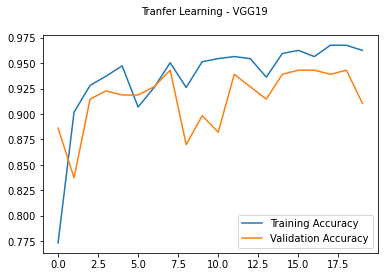

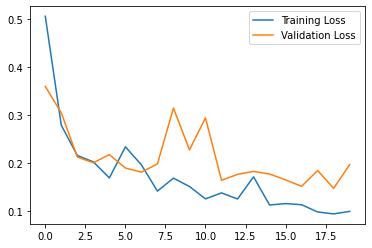

In [16]:
history = modelVGG19.history

plt.suptitle("Tranfer Learning - VGG19", fontsize=10)
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label ="Validation Accuracy")
plt.legend()
plt.show()
plt.close()

plt.plot(history.history["loss"], label ="Training Loss")
plt.plot(history.history["val_loss"], label ="Validation Loss")
plt.legend()
plt.show()
plt.close()

### 2. MobilNetV2


In [27]:
from tensorflow.keras.applications import MobileNetV2

In [28]:
K.clear_session()

base_mobilv2 = tf.keras.applications.MobileNetV2(
    include_top = False,
    input_shape = (224,224,3))

base_mobilv2.trainable = False 

mobilv2_model = models.Sequential()

mobilv2_model.add(base_mobilv2)
mobilv2_model.add(layers.Flatten())
mobilv2_model.add(layers.Dense(32, activation ="relu"))
mobilv2_model.add(layers.Dropout(0.5))
mobilv2_model.add(layers.Dense(1, activation ="sigmoid"))
mobilv2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 32)                2007072   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,265,089
Trainable params: 2,007,105
Non-trainable params: 2,257,984
______________________________________

In [32]:
mobilv2_model.compile(
    optimizer ="adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = mobilv2_model.fit(
    eyes_train,
    epochs = 20,
    validation_data = eyes_val
)

Epoch 1/20
31/31 [==============================] - 20s 566ms/step - loss: 0.9590 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
31/31 [==============================] - 16s 531ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
31/31 [==============================] - 16s 528ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
31/31 [==============================] - 16s 531ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
31/31 [==============================] - 16s 527ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
31/31 [==============================] - 16s 527ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
31/31 [==============================] - 16s 523ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000

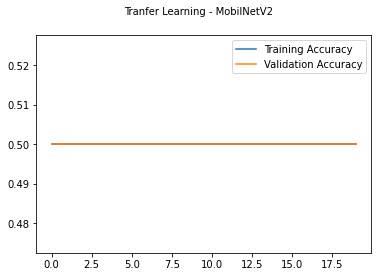

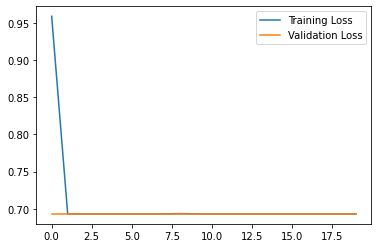

In [33]:
history = mobilv2_model.history

plt.suptitle("Tranfer Learning - MobilNetV2", fontsize=10)
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label ="Validation Accuracy")
plt.legend()
plt.show()
plt.close()

plt.plot(history.history["loss"], label ="Training Loss")
plt.plot(history.history["val_loss"], label ="Validation Loss")
plt.legend()
plt.show()
plt.close()

### 3. NasNet Mobile


In [34]:
from tensorflow.keras.applications import NASNetMobile

In [36]:
K.clear_session()

nasnet = tf.keras.applications.NASNetMobile(
   
    include_top = True,
    input_shape = None, 
    weights="imagenet")

nasnet.trainable = False

modelnasnet = models.Sequential()
modelnasnet.add(nasnet)
modelnasnet.add(layers.Flatten())
modelnasnet.add(layers.Dense(64, activation ="relu"))
modelnasnet.add(layers.Dense(1, activation ="sigmoid"))
modelnasnet.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 1000)              5326716   
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 64)                64064     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,390,845
Trainable params: 64,129
Non-trainable params: 5,326,716
_________________________________________________________________


In [37]:

modelnasnet.compile(
    optimizer ="adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = modelnasnet.fit(
    eyes_train,
    epochs = 20,
    validation_data = eyes_val)

#history_dictionary["nasnet"] = history.history

Epoch 1/20
31/31 [==============================] - 32s 678ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
31/31 [==============================] - 17s 550ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
31/31 [==============================] - 17s 555ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
31/31 [==============================] - 17s 555ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
31/31 [==============================] - 17s 543ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
31/31 [==============================] - 17s 546ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
31/31 [==============================] - 17s 544ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000

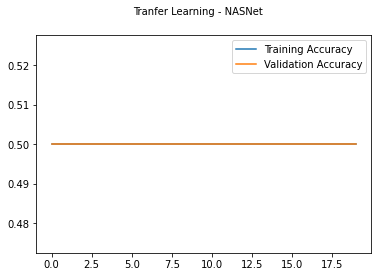

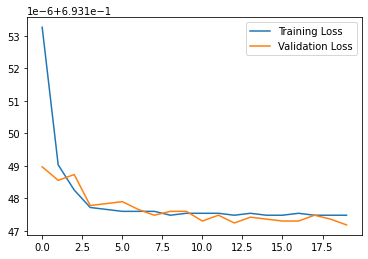

In [39]:
history = modelnasnet.history

plt.suptitle("Tranfer Learning - NASNet", fontsize=10)
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label ="Validation Accuracy")
plt.legend()
plt.show()
plt.close()

plt.plot(history.history["loss"], label ="Training Loss")
plt.plot(history.history["val_loss"], label ="Validation Loss")
plt.legend()
plt.show()
plt.close()

### 4. InceptionV3

In [40]:
from tensorflow.keras.applications import InceptionV3

In [41]:
K.clear_session()

incepV3 = tf.keras.applications.InceptionV3(
   
    include_top = True,
    input_shape = None, 
    weights="imagenet")

incepV3.trainable = False

modelincepv3 = models.Sequential()


#mobilv2_model.add(base_mobilv2)
#mobilv2_model.add(layers.Flatten())
#mobilv2_model.add(layers.Dense(32, activation ="relu"))


modelincepv3.add(incepV3)
modelincepv3.add(layers.Flatten())
modelincepv3.add(layers.Dense(128, activation ="relu"))
modelincepv3.add(layers.Dropout(0.2))
modelincepv3.add(layers.Dense(1, activation ="sigmoid"))
modelincepv3.summary()

96124928/96112376 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1000)              23851784  
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,980,041
Trainable params: 128,257
Non-trainable params: 23,851,784
_______________________________________

In [43]:
modelincepv3.compile(
    optimizer ="RMSprop",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = modelincepv3.fit(
    eyes_train,
    epochs = 20,
    validation_data = eyes_val
)

Epoch 1/20
31/31 [==============================] - 23s 593ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
31/31 [==============================] - 17s 538ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/20
31/31 [==============================] - 16s 533ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
31/31 [==============================] - 17s 539ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/20
31/31 [==============================] - 17s 538ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
31/31 [==============================] - 17s 535ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
31/31 [==============================] - 17s 538ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000

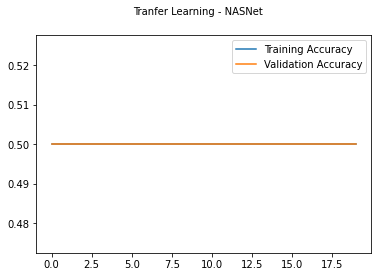

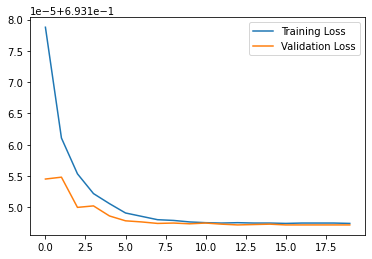

In [44]:
history = modelincepv3.history

plt.suptitle("Tranfer Learning - NASNet", fontsize=10)
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label ="Validation Accuracy")
plt.legend()
plt.show()
plt.close()

plt.plot(history.history["loss"], label ="Training Loss")
plt.plot(history.history["val_loss"], label ="Validation Loss")
plt.legend()
plt.show()
plt.close()